# Modelo RNN con gráficos de validacion y presentación

## bibliotecas

In [ ]:
# ==============================
# Libreries
# ==============================
import pandas as pd
import numpy as np
import random
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import time

## configuración

In [2]:
# ==============================
# PARTE 1 — Configuración Inicial y Carga de Datos
# ==============================

# ------------------------------
# 1. Fijar semilla para reproducibilidad
# ------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# ------------------------------
# 2. Cargar dataset final y poner 'Date' como índice
# ------------------------------
data_path = "../../data/processed/final_data.csv.gz"
data = pd.read_csv(data_path, compression='gzip', parse_dates=['Date'], index_col='Date')

print("Columnas del dataset:", list(data.columns))
print(f"Dimensiones dataset original: {data.shape}")

# ------------------------------
# 3. Filtrar rango temporal
# ------------------------------
start_date = "2005-01-01"
end_date = "2025-10-31"
data = data.loc[start_date:end_date]

print(f"Dimensiones dataset filtrado 2005-2025: {data.shape}")

# ------------------------------
# 4. Seleccionar columnas principales
# ------------------------------
# Columnas de interés para la RNN: precios BBVA, Santander y PCA
pca_cols = [col for col in data.columns if "PCA" in col]
main_cols = ['BBVA.MC_Close', 'SAN.MC_Close'] + pca_cols

data_rnn = data[main_cols]
print(f"Columnas seleccionadas para la RNN: {data_rnn.shape[1]}")

# ------------------------------
# 5. Visualización rápida
# ------------------------------
display(data_rnn)

Columnas del dataset: ['SAN.MC_Close', 'BKT.MC_Low', 'STOXX50E_Low', 'STOXX50E_Open', 'HSBC_Low', 'UNI.MC_Open', 'HSBC_Open', 'EURJPY.csv_Close', 'ECB_M3_SKK', 'IBEX_High', 'BBVA.MC_Low', 'MSCI_Financials.csv_High', 'IBEX_Close', 'SAB.MC_Low', 'UNI.MC_Low', 'EURJPY.csv_Open', 'UNI.MC_High', 'GDAXI_Close', 'URTH_Low', 'URTH_Close', 'GDAXI_Open', 'STOXX50E_Close', 'STOXX50E_High', 'BBVA.MC_Open', 'BKT.MC_Open', 'N225_Open', 'ECB_M3_HKD', 'FTSE_Close', 'EURJPY.csv_Low', 'FTSE_Low', 'UNI.MC_Close', 'JPM_Open', 'IBEX_Low', 'BKT.MC_Close', 'URTH_Open', 'HSBC_Close', 'ECB_M3_USD', 'GDAXI_Low', 'GDAXI_High', 'CABK.MC_Close', 'JPM_Close', 'SAB.MC_Close', 'SAB.MC_High', 'JPM_High', 'SAN.MC_Low', 'MSCI_Financials.csv_Open', 'FTSE_Open', 'BBVA.MC_Close', 'ECB_M3_CZK', 'FTSE_High', 'BBVA.MC_High', 'BKT.MC_High', 'EURJPY.csv_High', 'N225_High', 'SAN.MC_Open', 'MSCI_Financials.csv_Close', 'MSCI_Financials.csv_Low', 'N225_Close', 'URTH_High', 'IBEX_Open', 'ECB_M3_JPY', 'CABK.MC_High', 'CABK.MC_Open', 

,BBVA.MC_Close,SAN.MC_Close,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,-1.826990,9.380348,-1.741290,3.502204,-0.836790,3.841229,-5.521703,-1.800316,...,0.557657,0.282267,-0.342419,0.156220,-0.129392,0.314089,-0.252011,-1.024318,0.424503,-0.375780
2005-01-02,NaN,NaN,-1.829039,9.372219,-1.740167,3.499036,-0.836139,3.838251,-5.517482,-1.798937,...,0.556834,0.281893,-0.341843,0.155771,-0.129330,0.313644,-0.251855,-1.022809,0.423520,-0.375943
2005-01-03,4.446411,2.599646,13.872782,11.112143,-3.493010,-2.724641,0.472894,-2.873407,-4.582791,1.332656,...,2.515268,1.295396,-1.021902,0.445984,0.216710,-0.171002,0.269162,0.382764,0.353047,-0.440628
2005-01-04,4.422707,2.599646,14.893037,11.396897,-3.324143,-4.069852,0.663474,-2.580715,-5.022860,2.046954,...,1.853438,1.007899,-1.303535,-1.117715,1.556725,-1.142550,0.401012,0.559087,-0.074189,0.690906
2005-01-05,4.399001,2.562912,14.396275,11.309068,-3.677995,-3.095892,0.531848,-2.974937,-4.570563,1.700930,...,2.607476,1.358329,-1.250671,0.216616,0.716502,-0.387861,0.256955,0.455559,0.370632,-0.141541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,17.580000,8.865000,28.104901,-13.234004,-7.846998,9.143141,-0.996252,-5.593029,1.942455,-4.821068,...,-1.417439,0.270332,-0.035416,-3.233211,3.800043,-1.273700,1.316176,-4.846464,-0.938750,-0.844075
2025-10-30,17.280001,8.750000,27.821980,-12.739586,-7.443427,8.330550,-0.781672,-5.817917,1.940370,-5.307145,...,-0.837936,0.501435,0.858817,-5.682608,0.919306,0.624927,0.554233,-4.628295,-0.080748,-0.642446
2025-10-30,17.280001,8.750000,27.762862,-12.795248,-7.422621,8.325187,-0.777465,-5.887823,1.912897,-5.162755,...,-0.739295,0.549786,0.778913,-5.656696,0.947402,0.721576,0.793313,-4.729327,-0.076427,-0.544759


In [3]:
# ==============================
# PARTE 2 — Preprocesamiento y Preparación de Secuencias (TF)
# ==============================

# ------------------------------
# 1. Forward-fill / Backward-fill por si hay NaN
# ------------------------------
data_rnn = data_rnn.ffill().bfill()

# ------------------------------
# 2. Escalado de datos
# ------------------------------
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_rnn), 
                           columns=data_rnn.columns, index=data_rnn.index)

# ------------------------------
# 3. Función para crear secuencias
# ------------------------------
def create_sequences(data, target_cols=['BBVA.MC_Close', 'SAN.MC_Close'], 
                     lookback=5, horizon=1):
    X, y = [], []
    for i in range(lookback, len(data) - horizon + 1):
        X_seq = data.iloc[i - lookback:i].values
        y_seq = data.iloc[i:i + horizon][target_cols].values  # multi-step support
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# ------------------------------
# 4. Crear secuencias para single-step y multi-step
# ------------------------------
lookback = 5  # t-1 a t-5

# Single-step (1 día adelante)
horizon = 1
X_1, y_1 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# Multi-step (5 días adelante)
horizon = 5
X_5, y_5 = create_sequences(data_scaled, lookback=lookback, horizon=horizon)

# ------------------------------
# 5. Información de shapes
# ------------------------------
print("Single-step prediction:")
print("X_1.shape:", X_1.shape)  # (samples, 5, n_features)
print("y_1.shape:", y_1.shape)  # (samples, 1, target_cols)

print("\nMulti-step prediction (5 días):")
print("X_5.shape:", X_5.shape)
print("y_5.shape:", y_5.shape)

# ------------------------------
# Crear vector de fechas correspondiente a cada secuencia
# ------------------------------
dates_all_1 = data_scaled.index[lookback : len(data_scaled) - 1 + 1]  # para X_1, single-step
dates_all_5 = data_scaled.index[lookback : len(data_scaled) - 5 + 1]  # para X_5, multi-step 5 días


Single-step prediction:
X_1.shape: (9520, 5, 24)
y_1.shape: (9520, 1, 2)

Multi-step prediction (5 días):
X_5.shape: (9516, 5, 24)
y_5.shape: (9516, 5, 2)


In [4]:
display(data_scaled)

,BBVA.MC_Close,SAN.MC_Close,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,...,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,-0.317987,-0.848228,-1.358612,1.034835,-0.799572,0.591331,-0.149875,1.064762,-3.129804,-0.619318,...,0.424398,0.195495,-0.265098,0.057354,0.007225,0.216878,0.060512,-0.802750,0.384390,-0.203940
2005-01-02,-0.317987,-0.848228,-1.358793,1.034010,-0.799317,0.590667,-0.149740,1.063930,-3.127409,-0.618863,...,0.423959,0.195316,-0.264803,0.057127,0.007257,0.216649,0.060607,-0.801809,0.383783,-0.204064
2005-01-03,-0.317987,-0.848228,0.031795,1.210631,-1.197809,-0.714320,0.121685,-0.811318,-2.597119,0.416147,...,1.469783,0.681576,-0.612962,0.203968,0.186518,-0.033172,0.378494,0.074182,0.340327,-0.253016
2005-01-04,-0.326732,-0.848228,0.122151,1.239537,-1.159419,-0.996385,0.161202,-0.729539,-2.846789,0.652227,...,1.116359,0.543640,-0.757146,-0.587227,0.880694,-0.533976,0.458939,0.184072,0.076875,0.603309
2005-01-05,-0.335478,-0.880170,0.078157,1.230621,-1.239864,-0.792164,0.133909,-0.839685,-2.590182,0.537864,...,1.519023,0.711771,-0.730082,0.087913,0.445429,-0.144956,0.371046,0.119550,0.351170,-0.026672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,4.527693,4.599720,1.292224,-1.260770,-2.187647,1.774128,-0.182939,-1.571184,1.104929,-1.617695,...,-0.630324,0.189769,-0.107927,-1.657619,2.042812,-0.601580,1.017306,-3.184816,-0.456249,-0.558338
2025-10-30,4.417007,4.499723,1.267168,-1.210581,-2.095899,1.603743,-0.138446,-1.634019,1.103746,-1.778346,...,-0.320863,0.300648,0.349880,-2.896957,0.550488,0.377105,0.552424,-3.048848,0.072831,-0.405748
2025-10-30,4.417007,4.499723,1.261932,-1.216231,-2.091168,1.602619,-0.137574,-1.653550,1.088160,-1.730624,...,-0.268188,0.323846,0.308973,-2.883846,0.565043,0.426925,0.698293,-3.111813,0.075495,-0.331821


## modelo


In [ ]:
# ------------------------------
# Callback para métricas y tiempo
# ------------------------------
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_time_start
        self.times.append(elapsed)
        print(f"Epoch {epoch+1} - tiempo: {elapsed:.2f}s - "
              f"loss: {logs['loss']:.6f} - val_loss: {logs['val_loss']:.6f} - "
              f"mae: {logs['mae']:.6f} - val_mae: {logs['val_mae']:.6f}")

# ------------------------------
# Función LSTM
# ------------------------------
def build_fixed_lstm(input_shape, output_size=2):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, return_sequences=True,
                   kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=False,
                   kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(output_size))  # 2 salidas: BBVA y SAN
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ------------------------------
# Preparar datos
# ------------------------------
X = X_1
y = y_1.reshape(y_1.shape[0], y_1.shape[2])  # (samples, 2)

# División sincronizada
X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
    X, y, dates_all_1, test_size=0.2, random_state=SEED
)

input_shape = (X_train.shape[1], X_train.shape[2])
output_size = y_train.shape[1]  # 2

# ------------------------------
# Entrenamiento
# ------------------------------
model = build_fixed_lstm(input_shape, output_size)
time_callback = TimeHistory()
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, time_callback],
    verbose=0
)

c:\Proyectos - UAX\CRR-Prediccion_acciones\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - tiempo: 4.88s - loss: 0.197532 - val_loss: 0.066579 - mae: 0.132969 - val_mae: 0.073646
Epoch 2 - tiempo: 2.51s - loss: 0.053262 - val_loss: 0.031753 - mae: 0.091244 - val_mae: 0.067774
Epoch 3 - tiempo: 2.57s - loss: 0.031323 - val_loss: 0.028612 - mae: 0.083599 - val_mae: 0.088112
Epoch 4 - tiempo: 2.51s - loss: 0.025803 - val_loss: 0.022568 - mae: 0.086490 - val_mae: 0.084915
Epoch 5 - tiempo: 2.57s - loss: 0.020752 - val_loss: 0.013714 - mae: 0.080539 - val_mae: 0.059994
Epoch 6 - tiempo: 2.50s - loss: 0.019109 - val_loss: 0.015401 - mae: 0.078858 - val_mae: 0.075272
Epoch 7 - tiempo: 2.71s - loss: 0.017548 - val_loss: 0.024367 - mae: 0.077609 - val_mae: 0.099943
Epoch 8 - tiempo: 2.55s - loss: 0.018708 - val_loss: 0.010665 - mae: 0.078493 - val_mae: 0.053026
Epoch 9 - tiempo: 2.57s - loss: 0.015876 - val_loss: 0.011987 - mae: 0.074398 - val_mae: 0.061867
Epoch 10 - tiempo: 2.40s - loss: 0.019245 - val_loss: 0.017923 - mae: 0.081422 - val_mae: 0.084328
Epoch 11 - tiempo: 

### guardar modelo y scaler

In [14]:
# Guardar modelo en formato Keras moderno
model.save("../../results/models/lstm_256_128_drop0.3_0.2_bs32_final.keras")
print("Modelo guardado para deploy web.")

Modelo guardado para deploy web.


In [ ]:
# Guardar scaler (usado para escalar data_rnn)
joblib.dump(scaler, "../../results/models/scaler_lstm_256_128.pkl")
print("✅ Scaler guardado correctamente.")

### gráficas entrenamiento

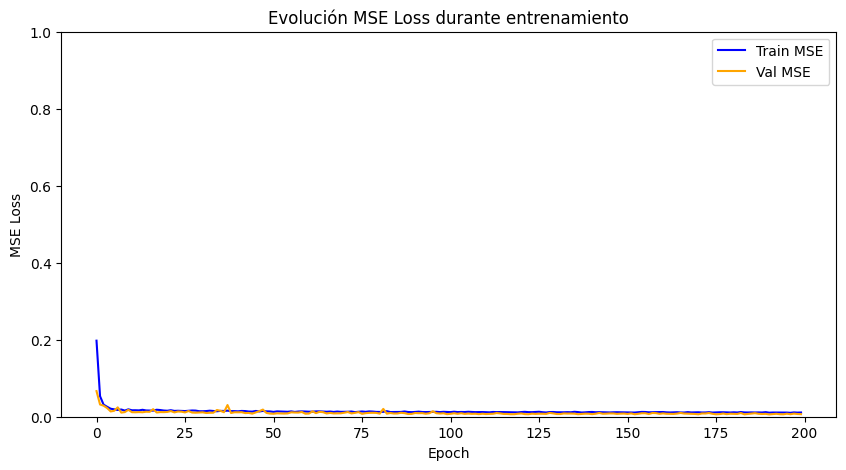

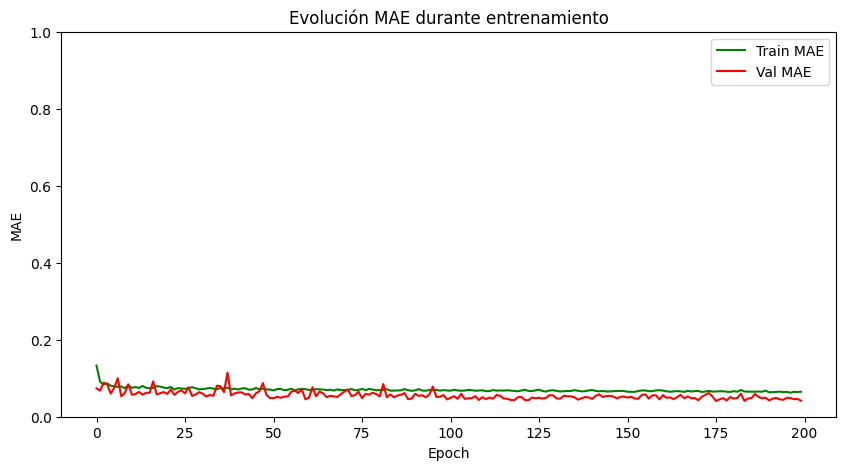

In [15]:
# ------------------------------
# GRAFICAS DE ENTRENAMIENTO
# ------------------------------

# Loss (MSE) entrenamiento y validación
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train MSE', color='blue')
plt.plot(history.history['val_loss'], label='Val MSE', color='orange')
plt.title('Evolución MSE Loss durante entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.ylim(0,1) 
plt.legend()
plt.show()

# MAE entrenamiento y validación
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Val MAE', color='red')
plt.title('Evolución MAE durante entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim(0,1) 
plt.legend()
plt.show()



### predicción

In [20]:
# ===============================
# Predicción
# ===============================
y_pred = model.predict(X_val)  # shape: (samples, 2)

# ------------------------------
# INVERTIR ESCALADO PARA RECUPERAR PRECIOS REALES (€)
# ------------------------------

# Reentrenar un scaler solo con las columnas objetivo (BBVA y SAN)
from sklearn.preprocessing import StandardScaler
scaler_target = StandardScaler()
scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

# Invertir escalado de las predicciones y los valores reales
y_val_inv  = scaler_target.inverse_transform(y_val)
y_pred_inv = scaler_target.inverse_transform(y_pred)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### predicción vs real: comparación error

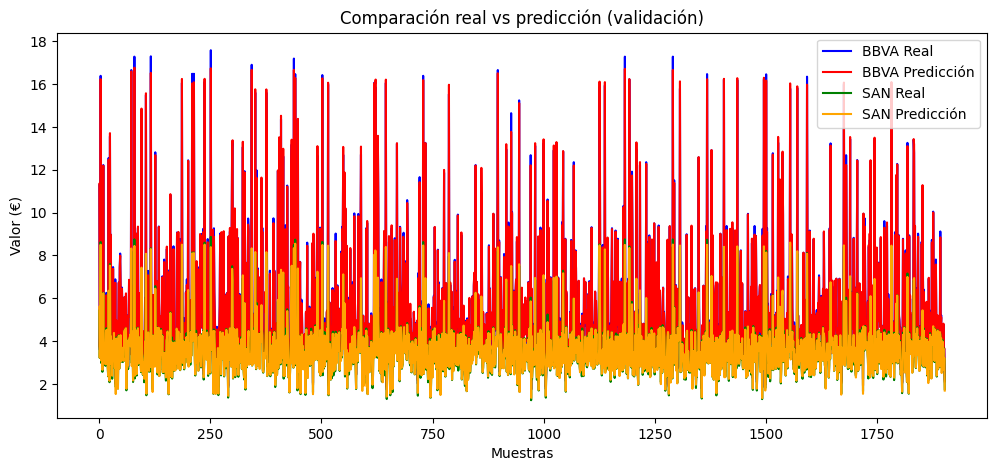

In [21]:
# ------------------------------- 
# Crear DataFrames para Santander y BBVA usando valores invertidos
# -------------------------------
df_val_bbva = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,0],  # BBVA
    'y_pred': y_pred_inv[:,0]
})

df_val_san = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,1],  # SAN
    'y_pred': y_pred_inv[:,1]
})

# Agregar columna 'month' para series mensuales
df_val_bbva['month'] = df_val_bbva['date'].dt.to_period('M')
df_val_san['month'] = df_val_san['date'].dt.to_period('M')

# ------------------------------
# Gráfico general: Predicción vs Real (todo el periodo)
# ------------------------------
plt.figure(figsize=(12,5))
plt.plot(df_val_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(df_val_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.plot(df_val_san['y_real'], label='SAN Real', color='green')
plt.plot(df_val_san['y_pred'], label='SAN Predicción', color='orange')
plt.title('Comparación real vs predicción (validación)')
plt.xlabel('Muestras')
plt.ylabel('Valor (€)')
plt.legend()
plt.show()


### df

In [ ]:
# ===============================
# 1️⃣ Invertir escalado de todas las predicciones y valores reales
# ===============================

# Reentrenar un scaler solo con las columnas objetivo (BBVA y SAN)
from sklearn.preprocessing import StandardScaler
scaler_target = StandardScaler()
scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

# Invertir escalado
y_val_inv  = scaler_target.inverse_transform(y_val)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Crear DataFrames completos con valores invertidos
df_val_bbva_inv = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,0],  # BBVA
    'y_pred': y_pred_inv[:,0]
})
df_val_san_inv = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,1],  # SAN
    'y_pred': y_pred_inv[:,1]
})

# Convertir a periodo mensual
df_val_bbva_inv['month'] = df_val_bbva_inv['date'].dt.to_period('M')
df_val_san_inv['month'] = df_val_san_inv['date'].dt.to_period('M')

### predicción vs real: mensual

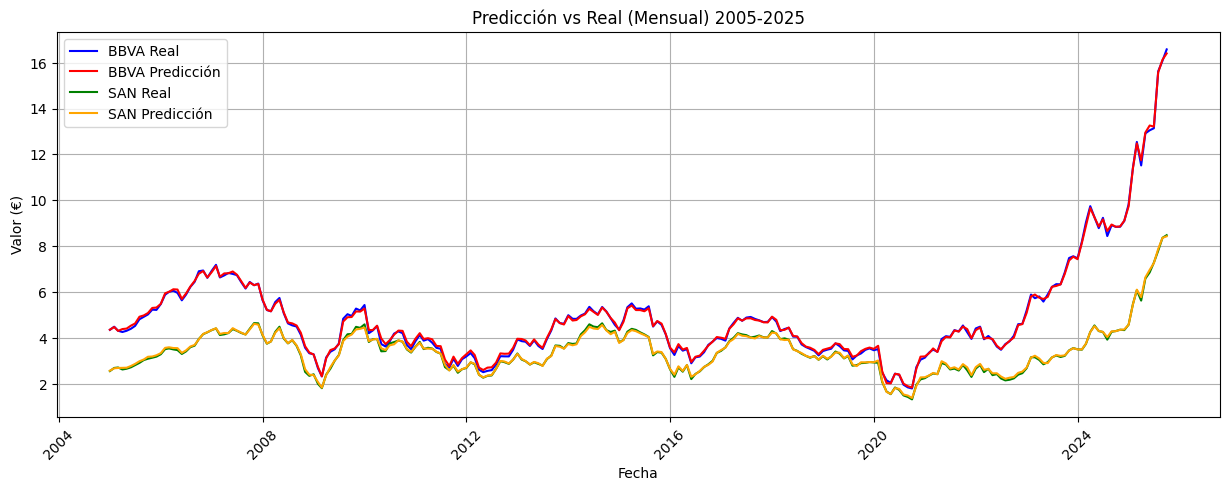

In [ ]:
# ===============================
# 2️⃣ Agrupar por mes para 2005-2025
# ===============================

# Filtrar el rango 2005-2025
df_bbva_monthly = df_val_bbva_inv[(df_val_bbva_inv['date'].dt.year >= 2005) &
                                  (df_val_bbva_inv['date'].dt.year <= 2025)]
df_san_monthly  = df_val_san_inv[(df_val_san_inv['date'].dt.year >= 2005) &
                                 (df_val_san_inv['date'].dt.year <= 2025)]

# Agrupar por mes y sacar promedio mensual
df_bbva_monthly_grouped = df_bbva_monthly.groupby('month').mean().reset_index()
df_san_monthly_grouped  = df_san_monthly.groupby('month').mean().reset_index()

# ===============================
# 3️⃣ Gráfico mensual 2005-2025
# ===============================
plt.figure(figsize=(15,5))

plt.plot(df_bbva_monthly_grouped['month'].dt.to_timestamp(), df_bbva_monthly_grouped['y_real'], label='BBVA Real', color='blue')
plt.plot(df_bbva_monthly_grouped['month'].dt.to_timestamp(), df_bbva_monthly_grouped['y_pred'], label='BBVA Predicción', color='red')

plt.plot(df_san_monthly_grouped['month'].dt.to_timestamp(), df_san_monthly_grouped['y_real'], label='SAN Real', color='green')
plt.plot(df_san_monthly_grouped['month'].dt.to_timestamp(), df_san_monthly_grouped['y_pred'], label='SAN Predicción', color='orange')

plt.title('Predicción vs Real (Mensual) 2005-2025')
plt.xlabel('Fecha')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


### predicción vs real: último mes

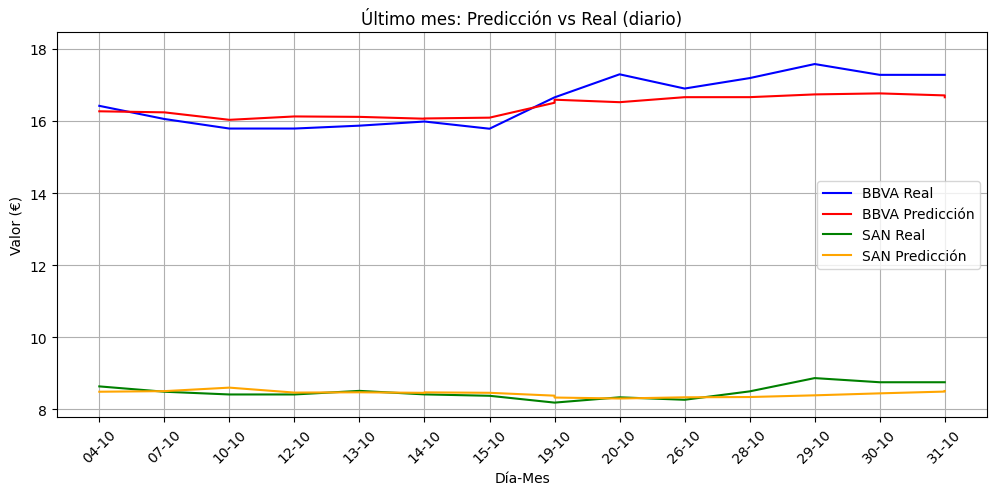

In [ ]:
# ===============================
# 1️⃣ Invertir escalado de todas las predicciones y valores reales            ===> esta solucionada la grafica en "4-preddiccion5dias"
# ===============================

# Reentrenar un scaler solo con las columnas objetivo (BBVA y SAN)
from sklearn.preprocessing import StandardScaler
scaler_target = StandardScaler()
scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

# Invertir escalado
y_val_inv  = scaler_target.inverse_transform(y_val)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Crear DataFrames completos con valores invertidos
df_val_bbva_inv = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,0],  # BBVA
    'y_pred': y_pred_inv[:,0]
})
df_val_san_inv = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,1],  # SAN
    'y_pred': y_pred_inv[:,1]
})

# Agregar columna 'month' para series mensuales
df_val_bbva_inv['month'] = df_val_bbva_inv['date'].dt.to_period('M')
df_val_san_inv['month'] = df_val_san_inv['date'].dt.to_period('M')


# ===============================
# 2️⃣ Gráfico: Último mes (diario)
# ===============================

# Filtrar último mes y ordenar
last_month = df_val_bbva_inv['month'].max()
df_last_bbva = df_val_bbva_inv[df_val_bbva_inv['month'] == last_month].sort_values('date')
df_last_san  = df_val_san_inv[df_val_san_inv['month'] == last_month].sort_values('date')

# Usar un único eje X (días del mes)
dates_plot = df_last_bbva['date'].dt.strftime('%d-%m')

plt.figure(figsize=(12,5))

plt.plot(dates_plot, df_last_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(dates_plot, df_last_bbva['y_pred'], label='BBVA Predicción', color='red')

# Alinear SAN por fecha
df_last_san_aligned = df_last_san.set_index('date').reindex(df_last_bbva['date']).reset_index()
plt.plot(dates_plot, df_last_san_aligned['y_real'], label='SAN Real', color='green')
plt.plot(dates_plot, df_last_san_aligned['y_pred'], label='SAN Predicción', color='orange')

plt.title('Último mes: Predicción vs Real (diario)')
plt.xlabel('Día-Mes')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.ylim(
    min(df_last_bbva[['y_real','y_pred']].min().min(),
        df_last_san[['y_real','y_pred']].min().min())*0.95,
    max(df_last_bbva[['y_real','y_pred']].max().max(),
        df_last_san[['y_real','y_pred']].max().max())*1.05
)
plt.legend()
plt.grid(True)
plt.show()


### separdo bbva y santander

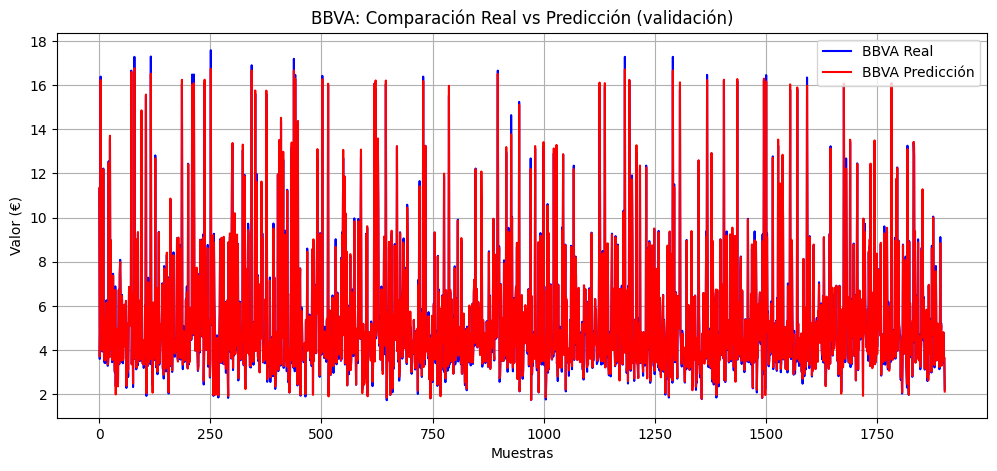

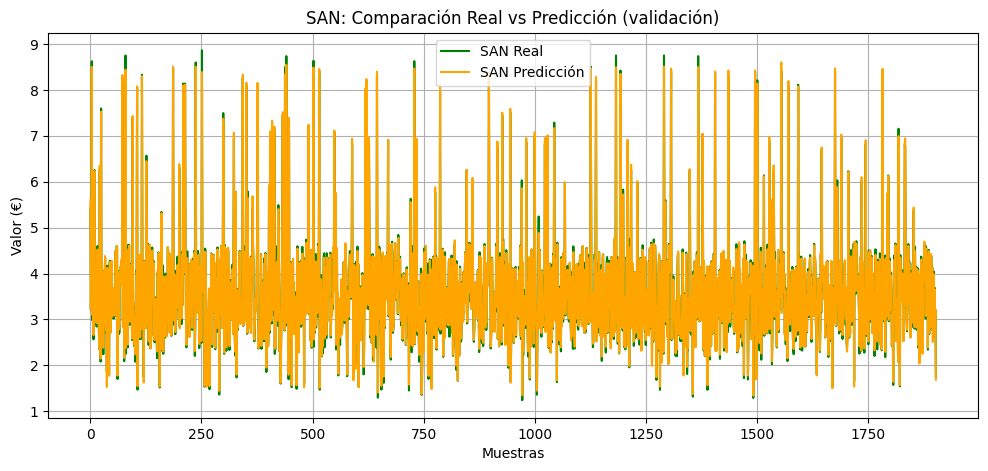

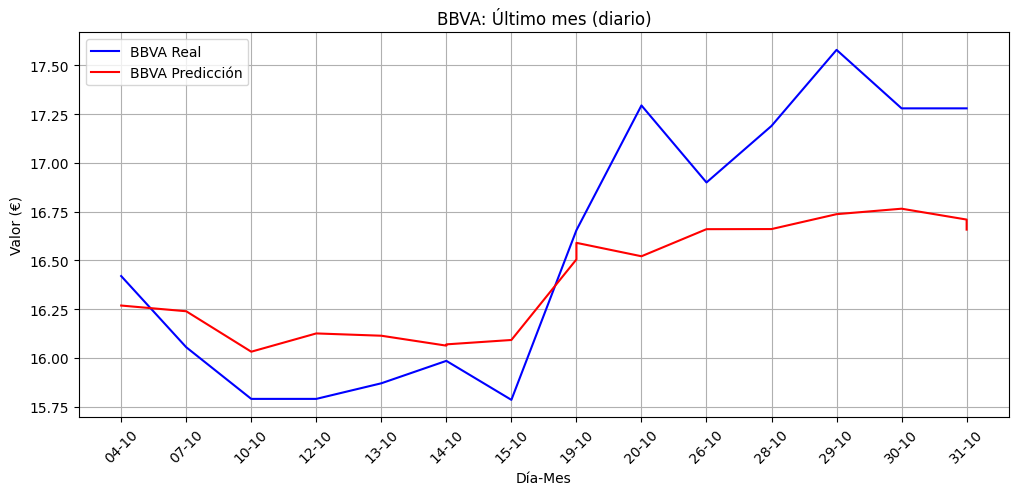

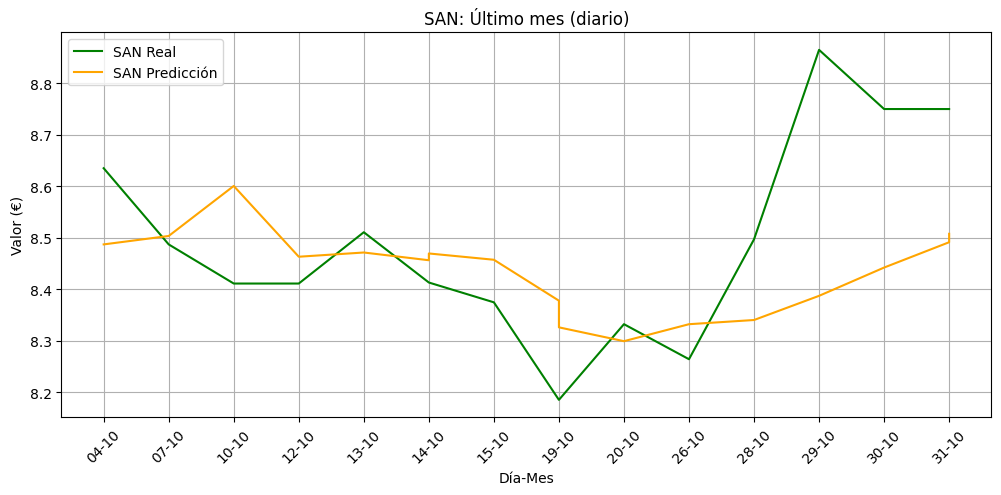

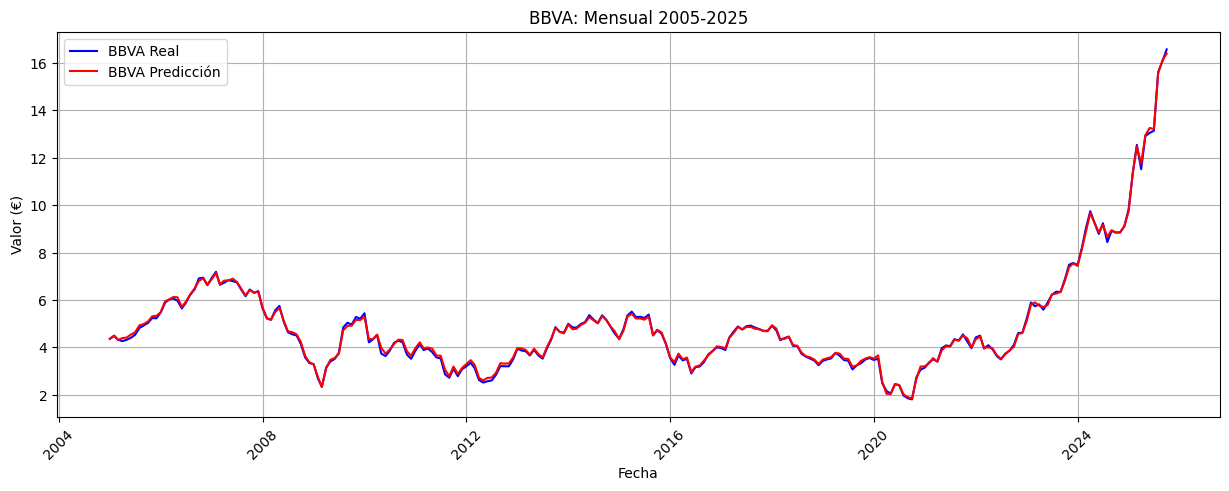

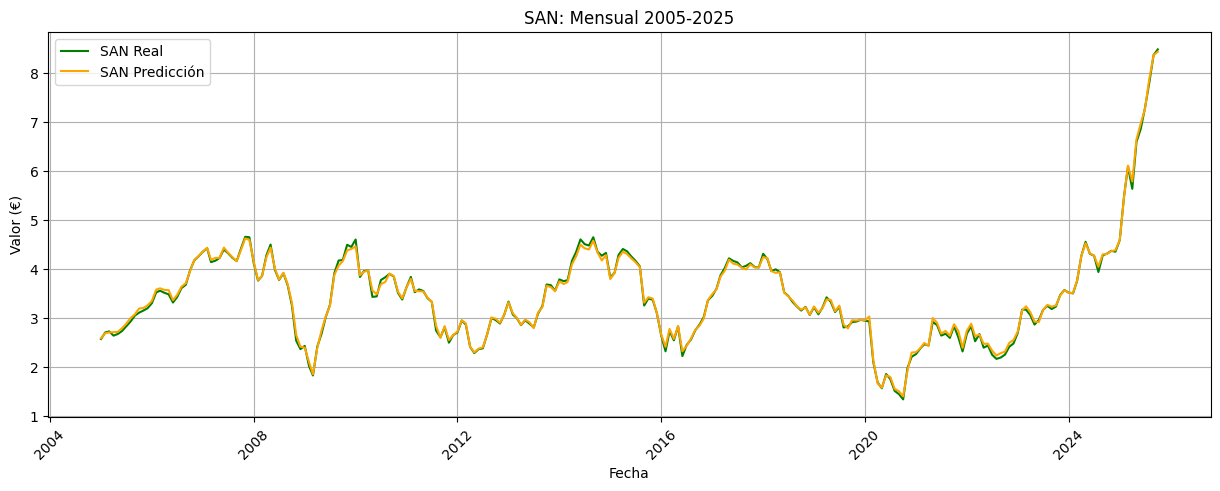

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ Invertir escalado de predicciones y valores reales
# ===============================
scaler_target = StandardScaler()
scaler_target.fit(data_rnn[['BBVA.MC_Close', 'SAN.MC_Close']])

y_val_inv  = scaler_target.inverse_transform(y_val)
y_pred_inv = scaler_target.inverse_transform(y_pred)

# DataFrames separados
df_val_bbva = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,0],
    'y_pred': y_pred_inv[:,0]
})
df_val_san = pd.DataFrame({
    'date': dates_val,
    'y_real': y_val_inv[:,1],
    'y_pred': y_pred_inv[:,1]
})

# Columna mes para agrupamiento mensual
df_val_bbva['month'] = df_val_bbva['date'].dt.to_period('M')
df_val_san['month'] = df_val_san['date'].dt.to_period('M')

# ===============================
# 2️⃣ Gráfico 1: Serie completa de validación
# ===============================
plt.figure(figsize=(12,5))
plt.plot(df_val_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(df_val_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.title('BBVA: Comparación Real vs Predicción (validación)')
plt.xlabel('Muestras')
plt.ylabel('Valor (€)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df_val_san['y_real'], label='SAN Real', color='green')
plt.plot(df_val_san['y_pred'], label='SAN Predicción', color='orange')
plt.title('SAN: Comparación Real vs Predicción (validación)')
plt.xlabel('Muestras')
plt.ylabel('Valor (€)')
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# 3️⃣ Gráfico 2: Último mes (diario)                      ===> esta solucionada la grafica en "4-preddiccion5dias"
# ===============================
last_month = df_val_bbva['month'].max()
df_last_bbva = df_val_bbva[df_val_bbva['month']==last_month].sort_values('date')
df_last_san  = df_val_san[df_val_san['month']==last_month].sort_values('date')
dates_plot = df_last_bbva['date'].dt.strftime('%d-%m')

plt.figure(figsize=(12,5))
plt.plot(dates_plot, df_last_bbva['y_real'], label='BBVA Real', color='blue')
plt.plot(dates_plot, df_last_bbva['y_pred'], label='BBVA Predicción', color='red')
plt.title('BBVA: Último mes (diario)')
plt.xlabel('Día-Mes')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
df_last_san_aligned = df_last_san.set_index('date').reindex(df_last_bbva['date']).reset_index()
plt.plot(dates_plot, df_last_san_aligned['y_real'], label='SAN Real', color='green')
plt.plot(dates_plot, df_last_san_aligned['y_pred'], label='SAN Predicción', color='orange')
plt.title('SAN: Último mes (diario)')
plt.xlabel('Día-Mes')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# ===============================
# 4️⃣ Gráfico 3: Serie mensual 2005-2025
# ===============================
# Filtrar rango 2005-2025
df_bbva_monthly = df_val_bbva[(df_val_bbva['date'].dt.year>=2005) & (df_val_bbva['date'].dt.year<=2025)]
df_san_monthly  = df_val_san[(df_val_san['date'].dt.year>=2005) & (df_val_san['date'].dt.year<=2025)]

# Agrupar por mes
df_bbva_monthly_grouped = df_bbva_monthly.groupby('month').mean().reset_index()
df_san_monthly_grouped  = df_san_monthly.groupby('month').mean().reset_index()

plt.figure(figsize=(15,5))
plt.plot(df_bbva_monthly_grouped['month'].dt.to_timestamp(), df_bbva_monthly_grouped['y_real'], label='BBVA Real', color='blue')
plt.plot(df_bbva_monthly_grouped['month'].dt.to_timestamp(), df_bbva_monthly_grouped['y_pred'], label='BBVA Predicción', color='red')
plt.title('BBVA: Mensual 2005-2025')
plt.xlabel('Fecha')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df_san_monthly_grouped['month'].dt.to_timestamp(), df_san_monthly_grouped['y_real'], label='SAN Real', color='green')
plt.plot(df_san_monthly_grouped['month'].dt.to_timestamp(), df_san_monthly_grouped['y_pred'], label='SAN Predicción', color='orange')
plt.title('SAN: Mensual 2005-2025')
plt.xlabel('Fecha')
plt.ylabel('Valor (€)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()
